# Sprint 14 - Machine Learning for Texts

## Project Overview

### Project Description

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. **The goal is to train a model to automatically detect negative reviews.** You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. **The model will need to have an F1 score of at least 0.85.**

### Project Instructions
1. Project Instructions
2. Load the data.
3. Preprocess the data, if required.
4. Conduct an EDA and make your conclusion on the class imbalance.
5. Preprocess the data for modeling.
6. Train at least three different models for the given train dataset.
7. Test the models for the given test dataset.
8. Compose a few of your own reviews and classify them with all the models.
9. Check for differences between the testing results of models in the above two points. Try to explain them.
10. Present your findings.

**_Project Notes_**
- We suggest trying classification models based on logistic regression and gradient boosting, but feel free to try other methods.
- You don't have to use BERT for the project because it is very demanding for computational power and will be very slow on the CPU for the complete dataset.

### Data Description

The data is stored in the `imdb_reviews.tsv` file. 

The data was provided by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

Here's the description of the selected fields:

 - `review`: the review text
 - `pos`: the target, '0' for negative and '1' for positive
 - `ds_part`: 'train'/'test' for the train/test part of dataset, correspondingly
 
*There are other fields in the dataset. Feel free to explore them if you'd like.*

## Initialization

### Import Libraries & Make Configurations for Analysis

In [1]:
# Import libraries required for this analysis
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
# For plotting
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

*Cell below is used to align the tables in the markdown to the left*

In [4]:
%%html
<style>
table {float:left}
</style>

## Load Data

In [5]:
# Read in data csv and convert to dataframe
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

### View Sample of Dataset

In [6]:
# Print sample of the data frame
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


## Explore Dataset

In [7]:
# Use print so I don't lose outputs

# Check for missing values
print('Check for Missing Values')
print(df_reviews.isna().sum())
print()


# Check values for each column
print('Describe Dataframe')
print(df_reviews.describe())
print()

# Check data types
print('Check Data Types')
print(df_reviews.info())
print()

# Check for Duplicates
print('Count of Duplicated Rows')
print(df_reviews.duplicated().sum())
print()

Check for Missing Values
tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

Describe Dataframe
         start_year      is_adult  average_rating         votes        rating  \
count  47331.000000  47331.000000    47329.000000  4.732900e+04  47331.000000   
mean    1989.631235      0.001732        5.998278  2.556292e+04      5.484608   
std       19.600364      0.041587        1.494289  8.367004e+04      3.473109   
min     1894.000000      0.000000        1.400000  9.000000e+00      1.000000   
25%     1982.000000      0.000000        5.100000  8.270000e+02      2.000000   
50%     1998.000000      0.000000        6.300000  3.197000e+03      4.000000   
75%     2004.00000

In [8]:
# View rows with missing values
df_reviews[df_reviews.isnull().any(axis=1)]

# Drop these two rows from df_reviews because data is missing for both votes and average_rating
df_reviews = df_reviews.dropna(axis='columns')

# Check again for rows with missing data
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

**Finding** - 
- Reviews are for movies from 1894 to 2010. I didn't realize humans were making films this early :)
- The dataset contains around ~47k reviews
- There aren't any duplicated reviews (rows)
- There were two rows that had missing data - These were removed
- Ratings look to be out of 10. The mean rating is 5.99. The max rating is 9.7...so close to perfect.  

Let's check the number of movies and reviews over years.

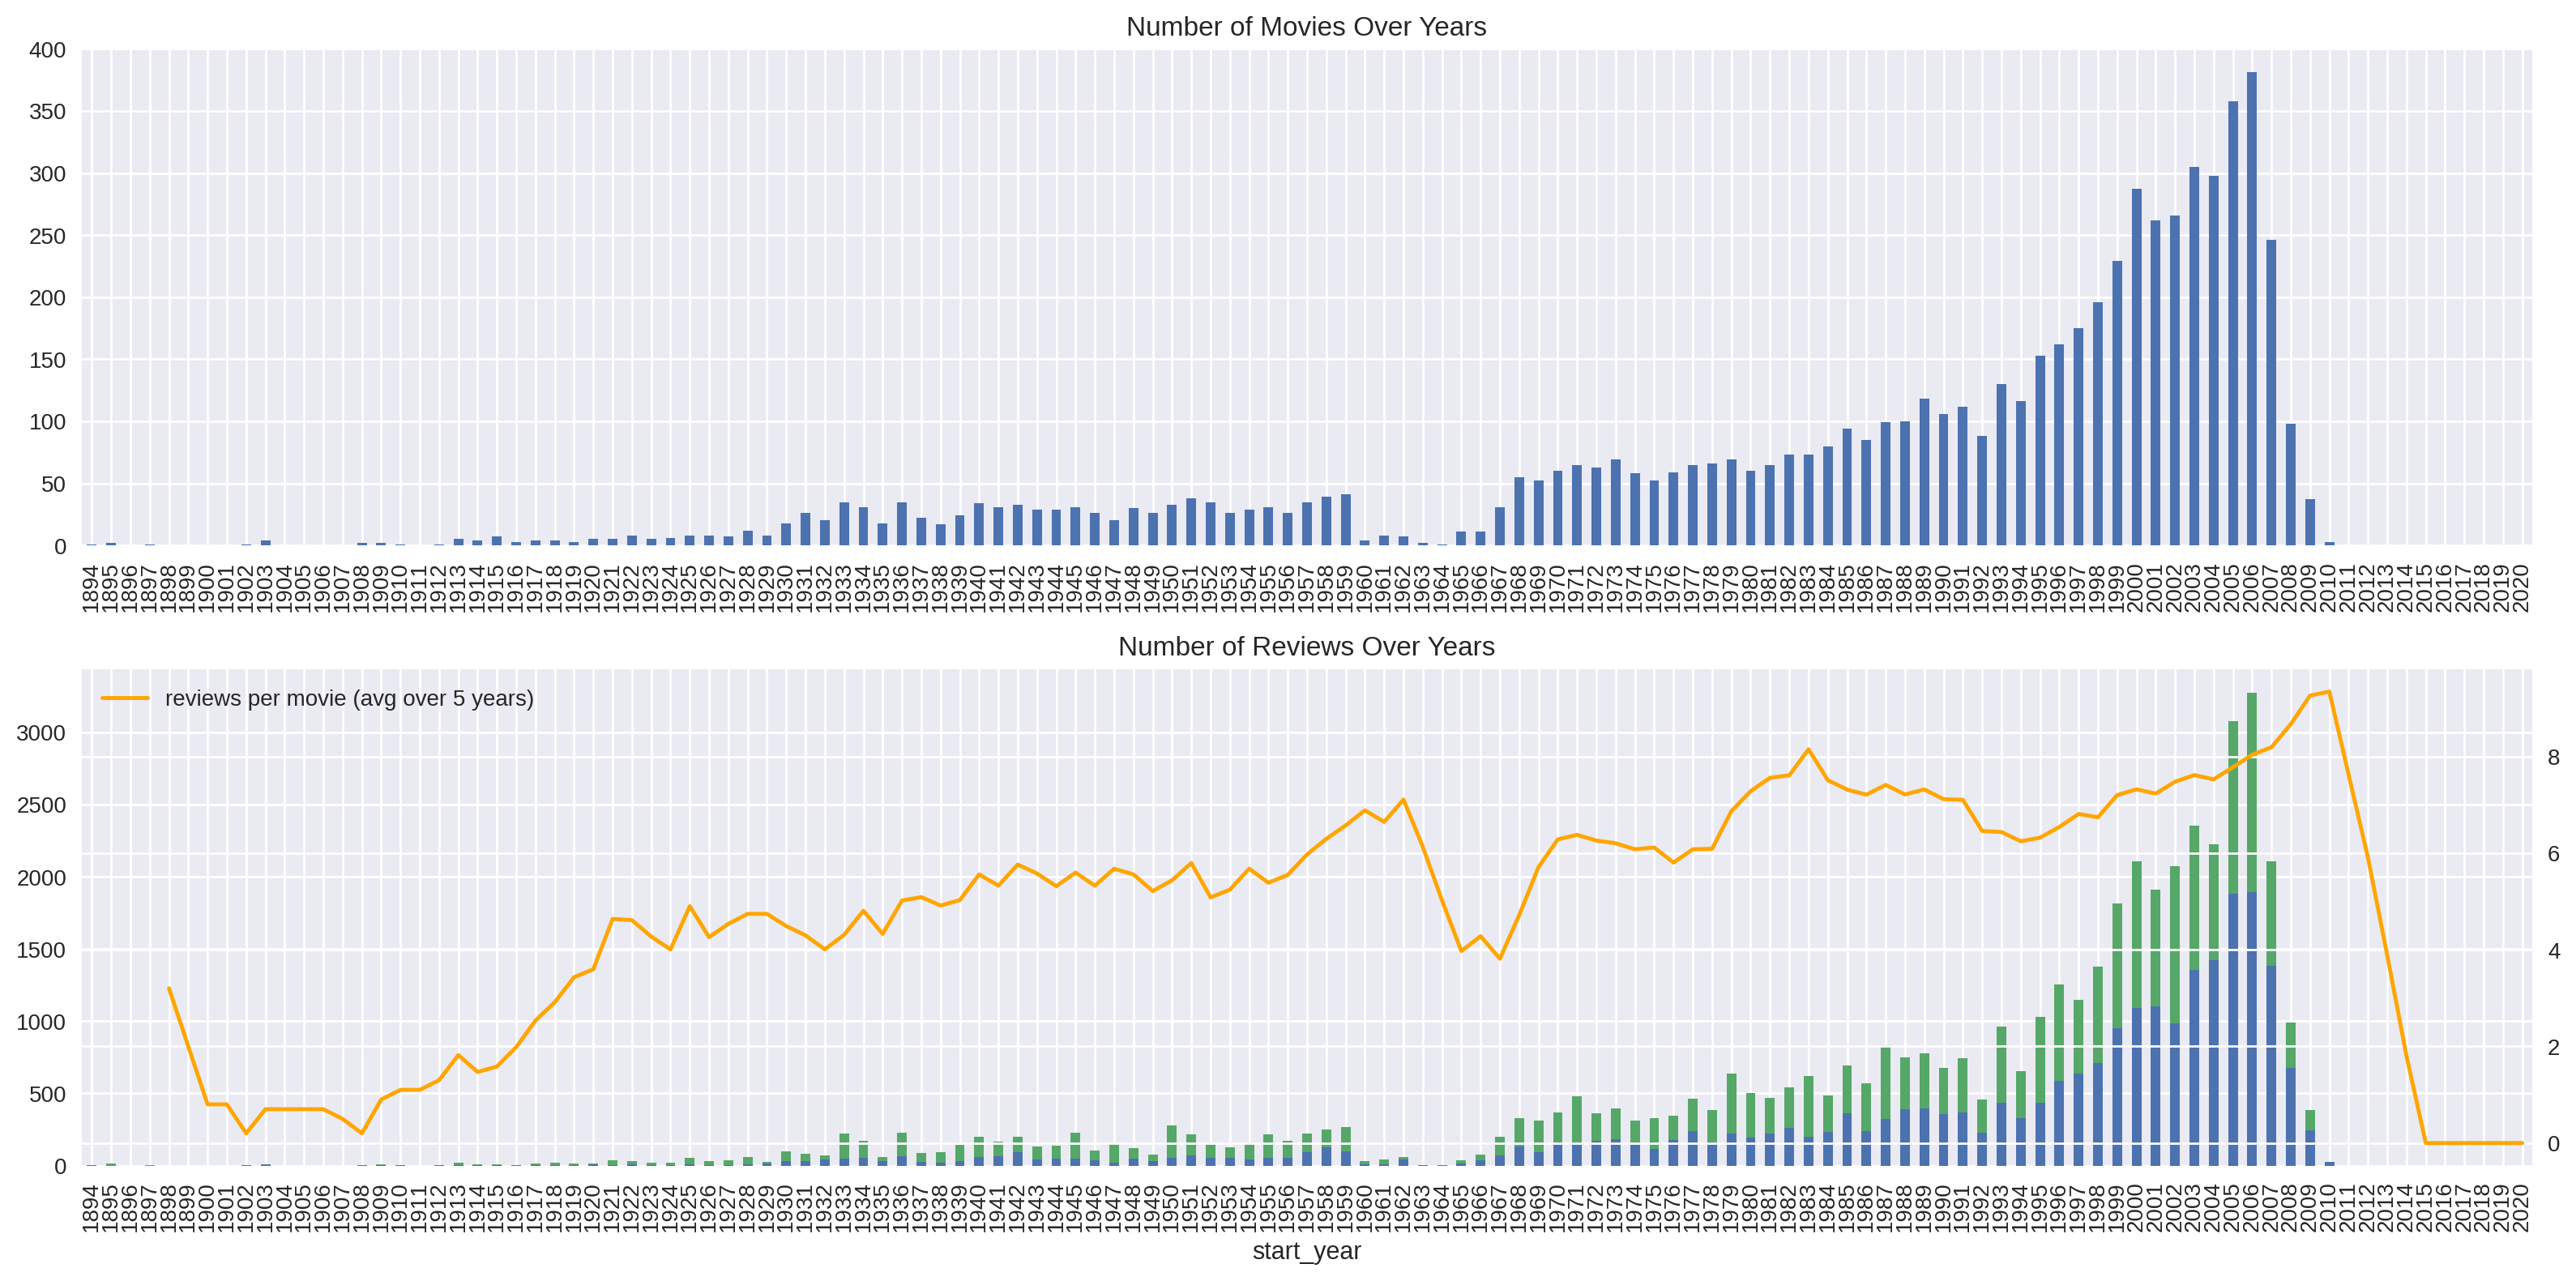

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

**Finding** - From the dataset we can see that over time, both the number of movies and reviews have increased. The bulk of movies and reviews come from within the last two or three decades.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

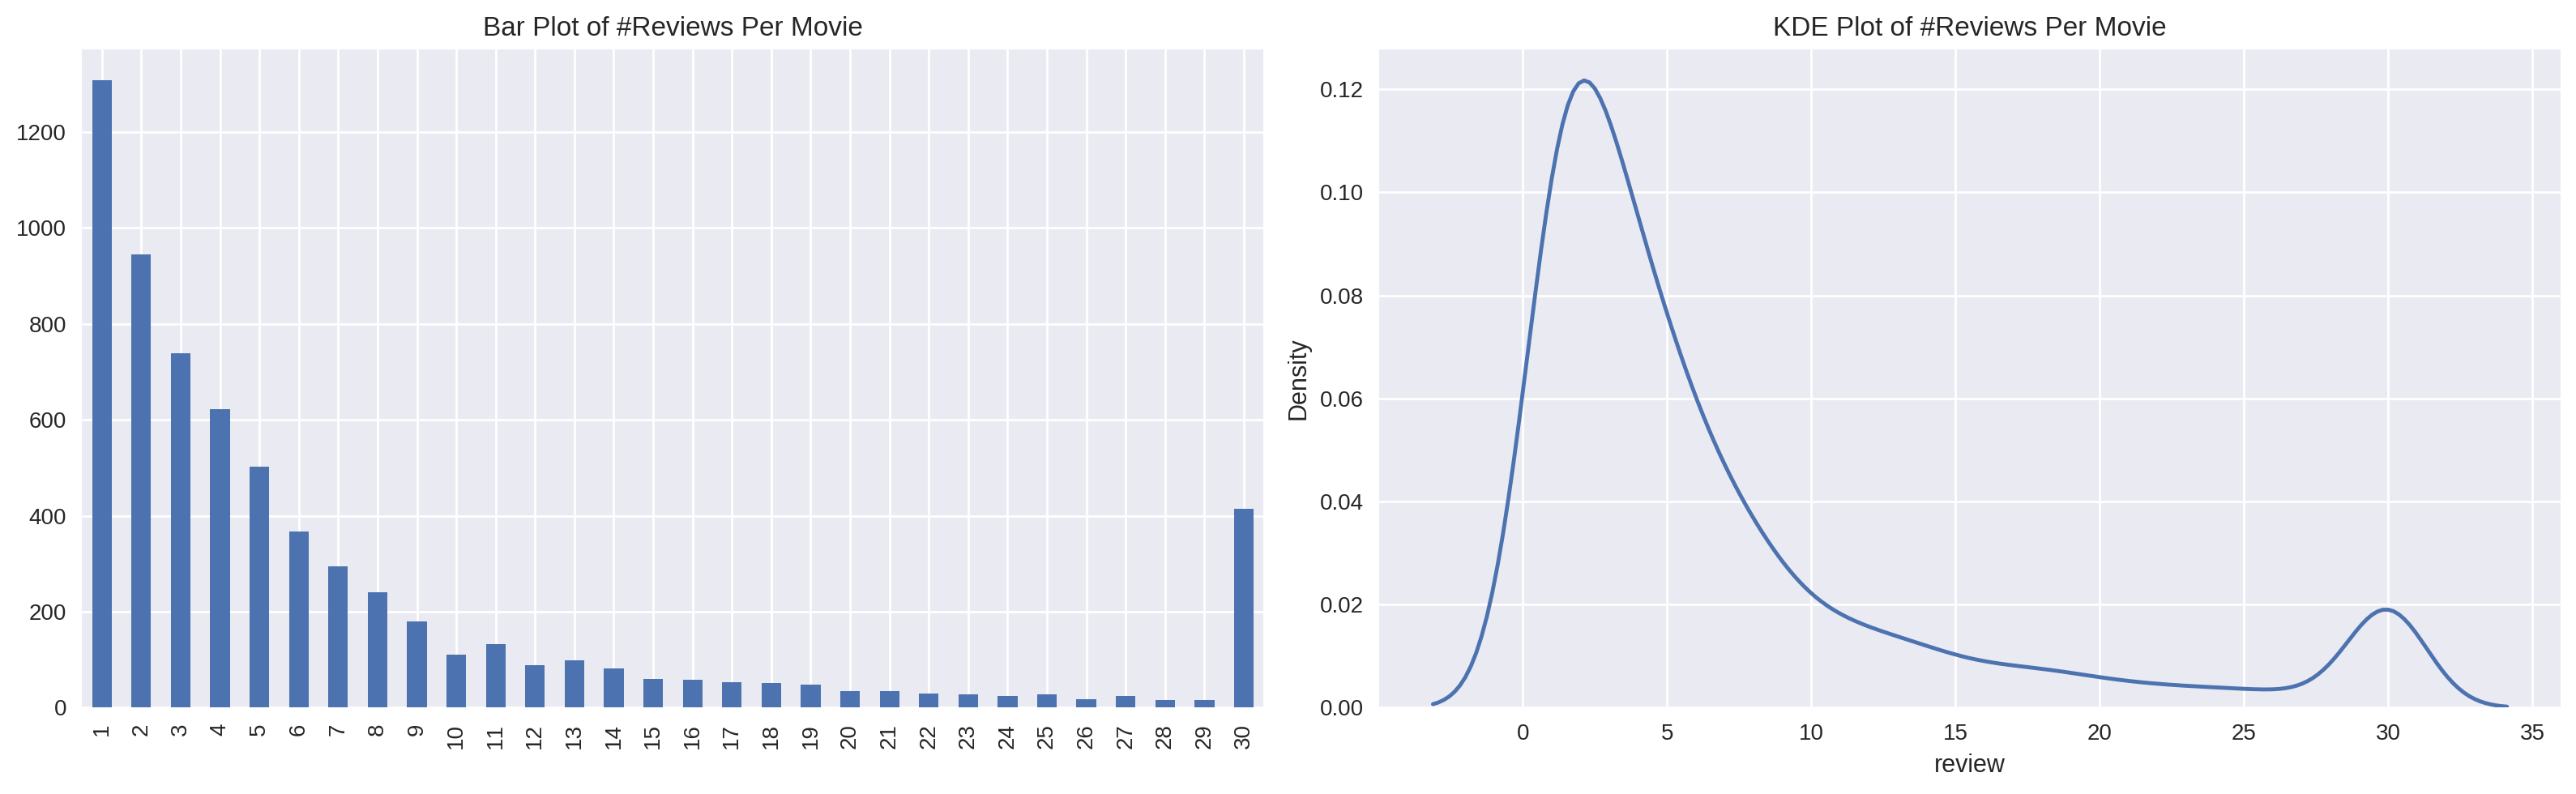

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

**Finding** - The majority of movies have one review, but the mean number of reviews per movie looks to be around 3. The distribtuion is skewed right

In [11]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

ds_part  pos
test     0      11803
         1      11732
train    0      11912
         1      11884
Name: pos, dtype: int64


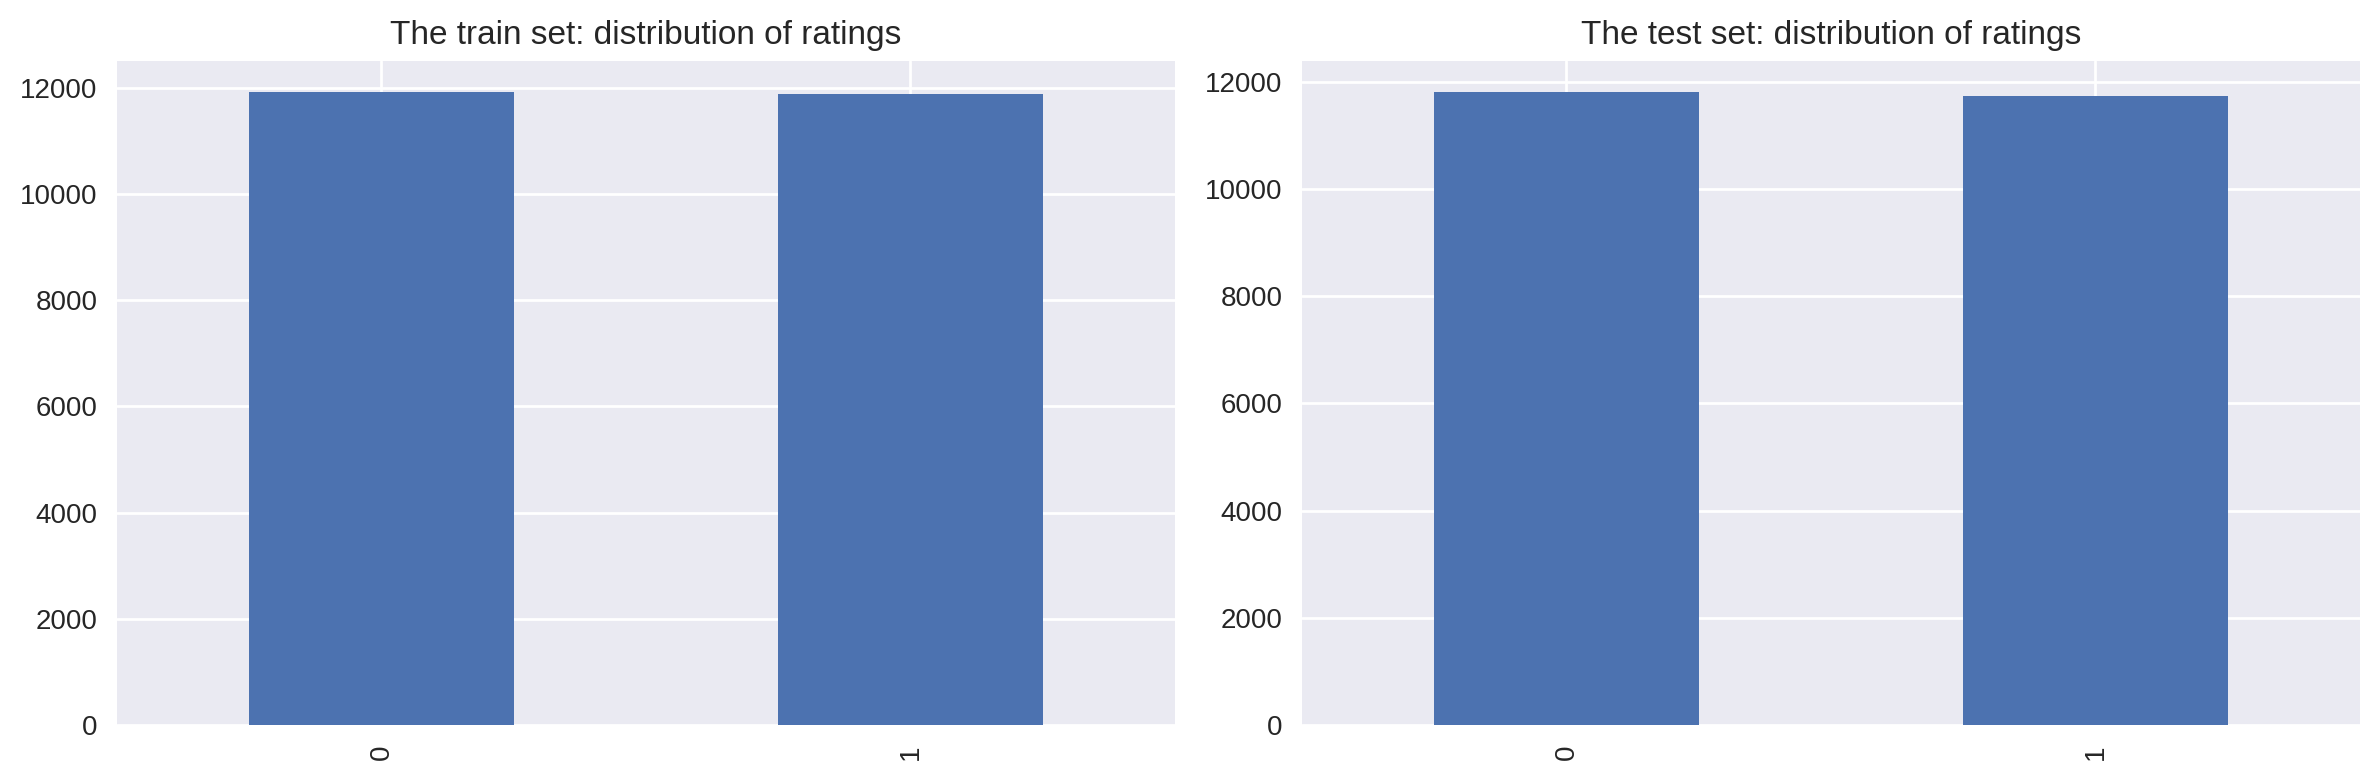

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['pos'].value_counts().sort_index()
dft.plot.bar(ax=ax)
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['pos'].value_counts().sort_index()
dft.plot.bar(ax=ax)
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

print(df_reviews.groupby('ds_part')['pos'].value_counts())


**Finding** - Between the training and test sets, the ratio of positive (1) and negative (0) reviews is balanced (near 50-50 split for each split)

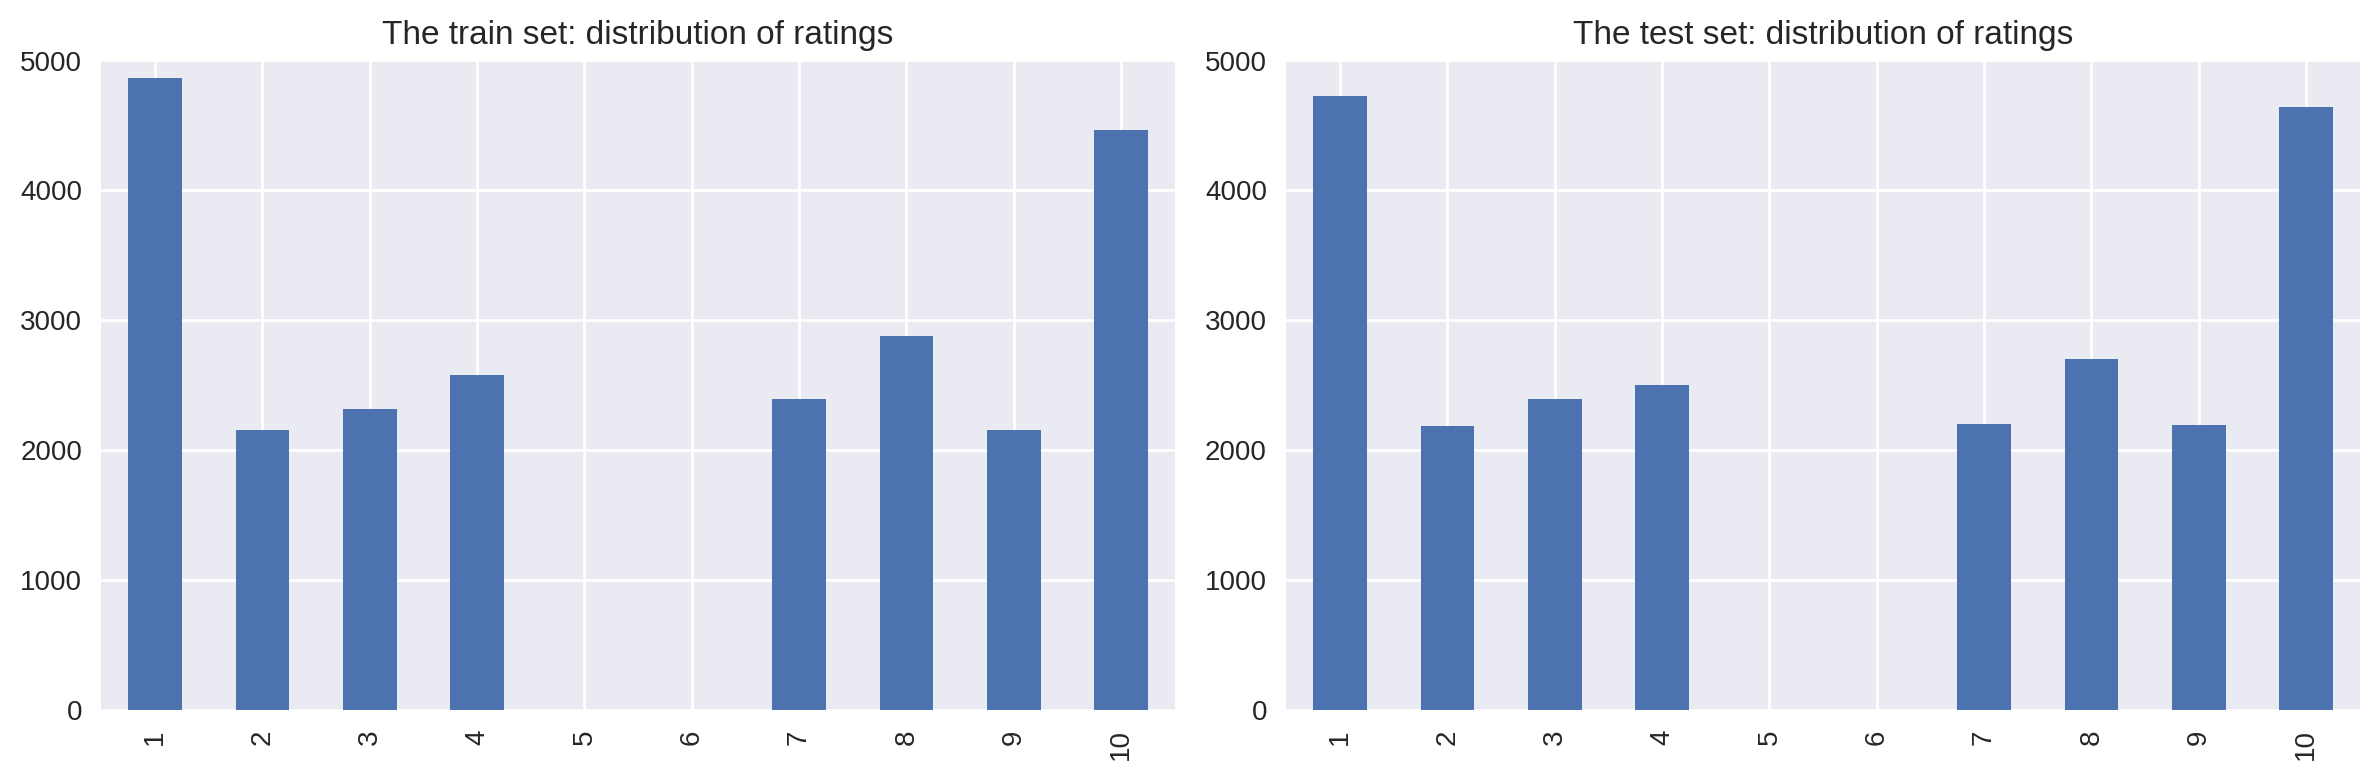

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

**Finding** - 5 and 6 seem to be considered as neutral ratings. Anything below 5 is negative. Anything above 6 is positive. People see to give either very positive reviews or very negative reviews, hence the large volume of 1 and 10 reviews. 

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


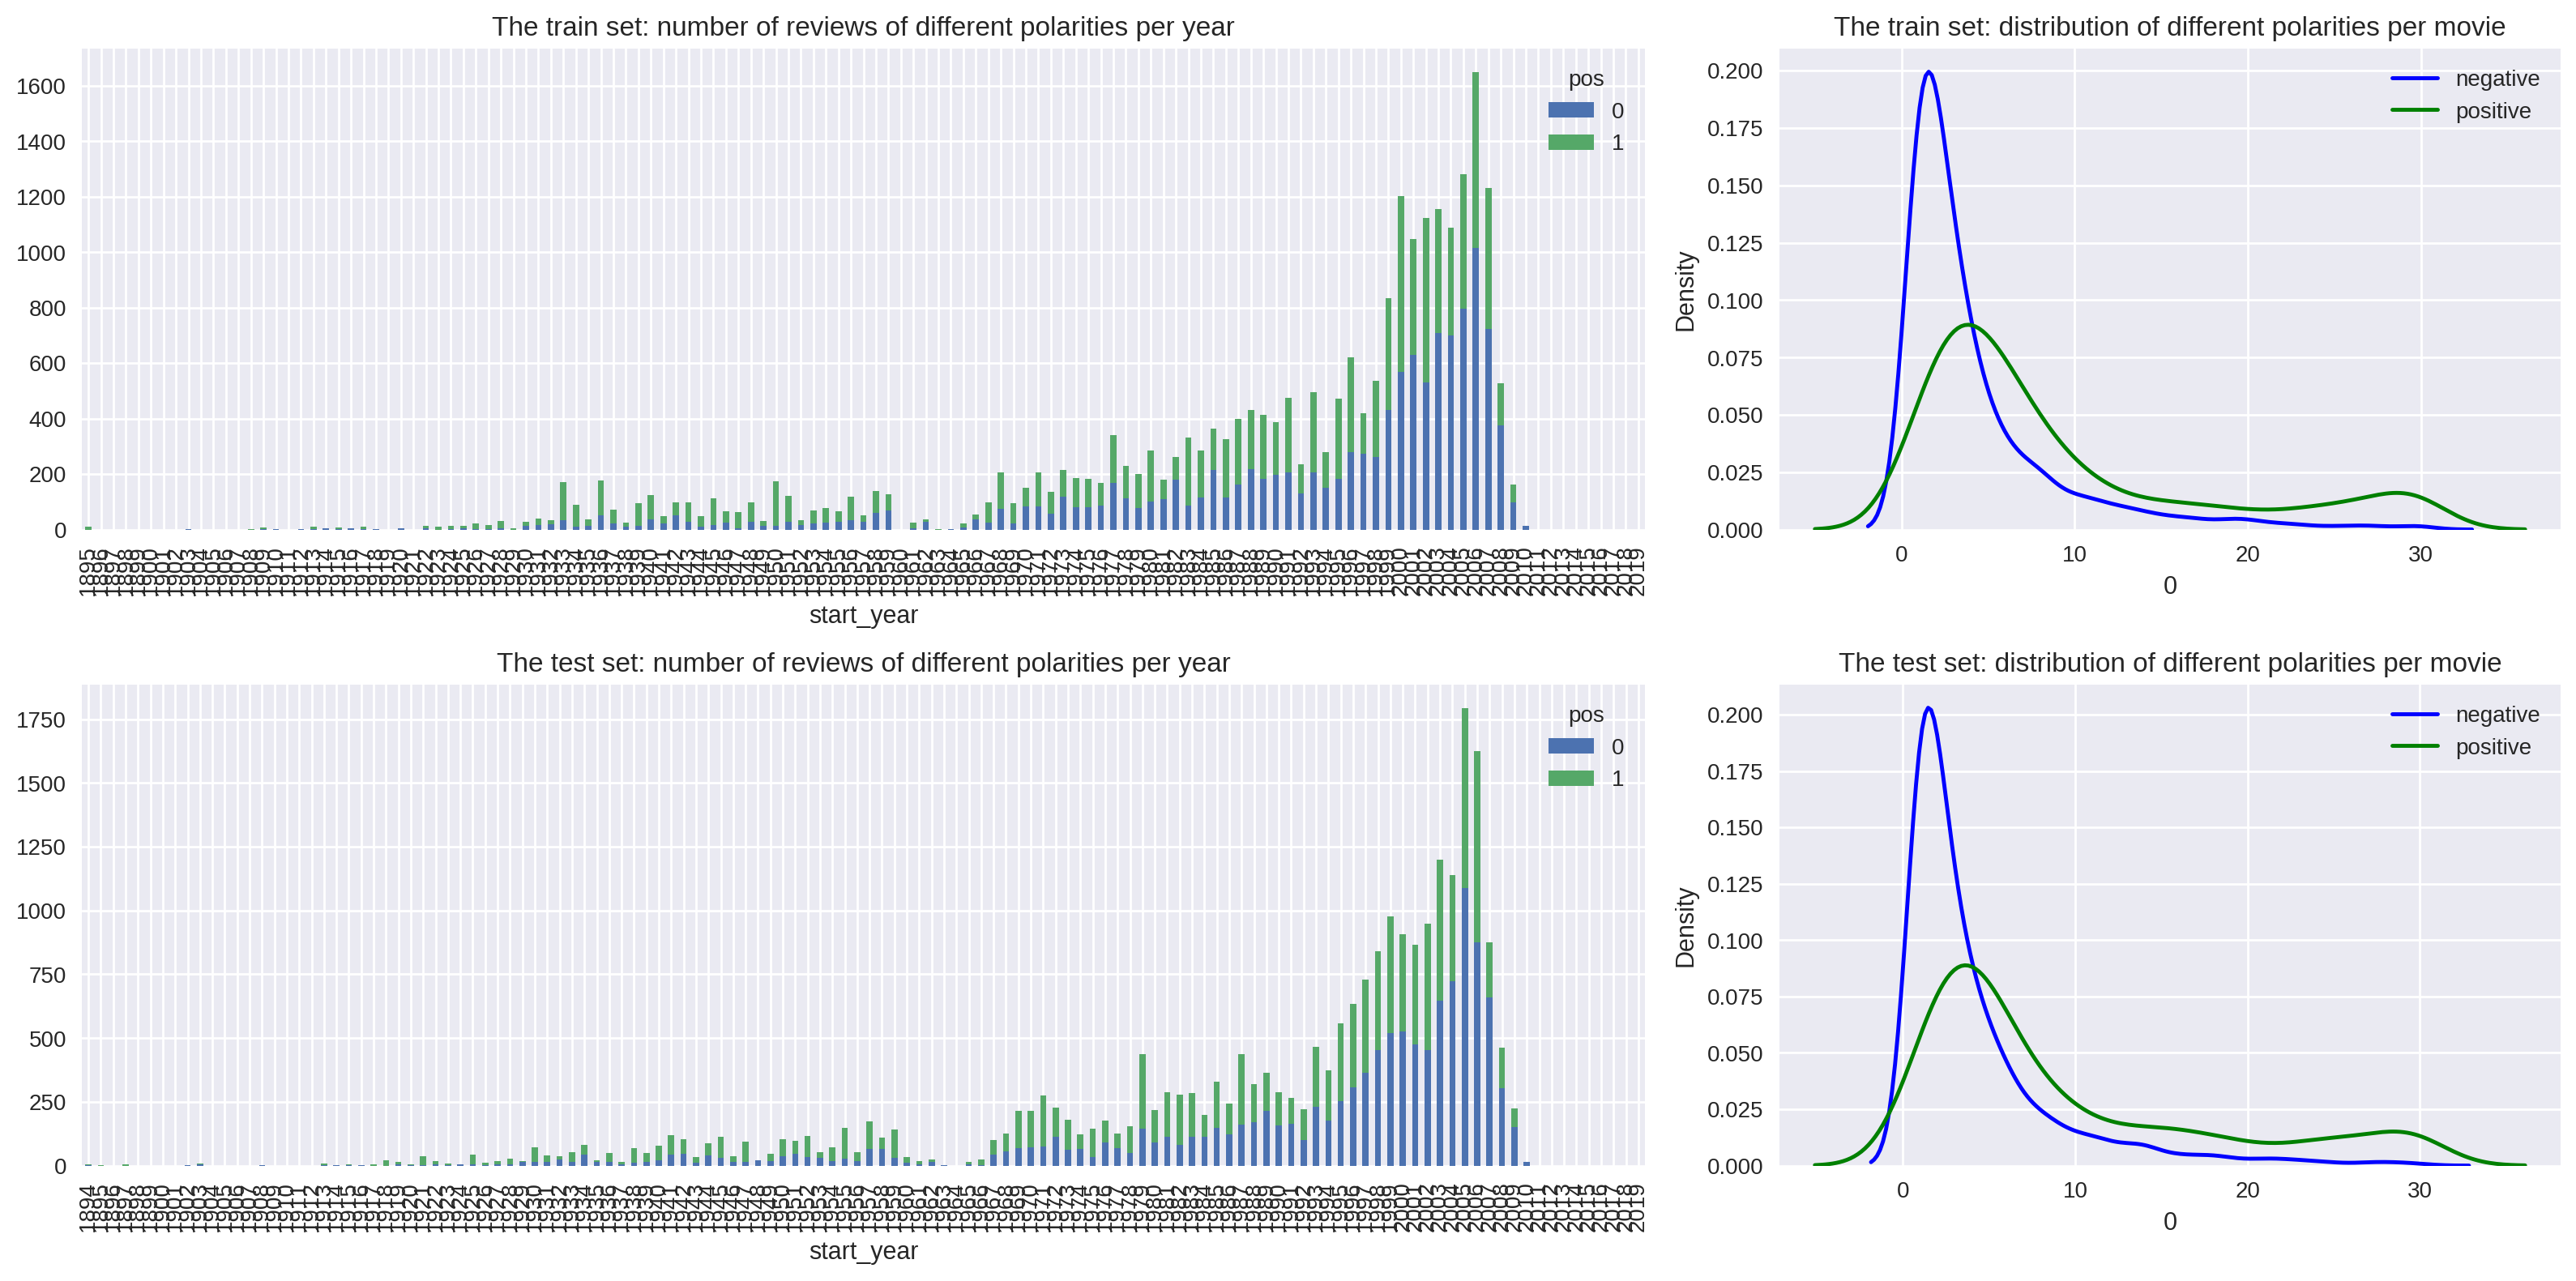

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

**Finding** - The distirubtion of different polarities per year are similar across test and training sets

### Exploratory Data Analysis Findings Summarized
Below are my findings from the exploratory data analysis - 
- From the dataset we can see that over time, both the number of movies and reviews have increased. The bulk of movies and reviews come from within the last two or three decades.
- The majority of movies have one review, but the mean number of reviews per movie looks to be around 3. The distribtuion is skewed right
- Between the training and test sets, the ratio of positive (1) and negative (0) reviews is balanced (near 50-50 split for each split)
- 5 and 6 seem to be considered as neutral ratings. Anything below 5 is negative. Anything above 6 is positive. People see to give either very positive reviews or very negative reviews, hence the large volume of 1 and 10 reviews. 
- The distirubtion of different polarities per year are similar across test and training sets

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [15]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [16]:
# For regex
import re

# Tokenize/Normalize - Create function to keep only letters and make strings lowercase
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: " ".join(re.sub(r'[^A-Za-z]', ' ', x.lower()).split()))

# Print single normalized review
df_reviews['review_norm'][0]

'the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but that s not what i got out of it i didn t get anything in the first half there s a new character without introduction in every other scene the first half hour is completely incomprehensible the rest is just one long annoying underlit chase scene there s always an irritating sound in the background whether it s a loud watch ticking a blaring siren a train whistling or even the horrible score by quincy jones there are a lot of parts that are laughably bad too like the bad guys chasing beatty on thin ice with a car or the police arriving at the scene roughly fifteen times i really hated this movie'

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [17]:
# Split into Test & Train sets
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Create features - Use pos column which has positive or negative sentiment
features_train = df_reviews_train.drop(['pos'], axis=1)
features_test = df_reviews_test.drop(['pos'], axis=1)

# Create Targets
target_train = df_reviews_train['pos']
target_test = df_reviews_test['pos']

# Print shape
print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 16)
(23535, 16)


### Modeling & Evaluation on Training Data
In this section, I will evaluate the performance of each models ability to predict sentiment after training models on training data and fitting to test features.

### Model 0 - Constant
Use DummyClassifier to compare other models performance to

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


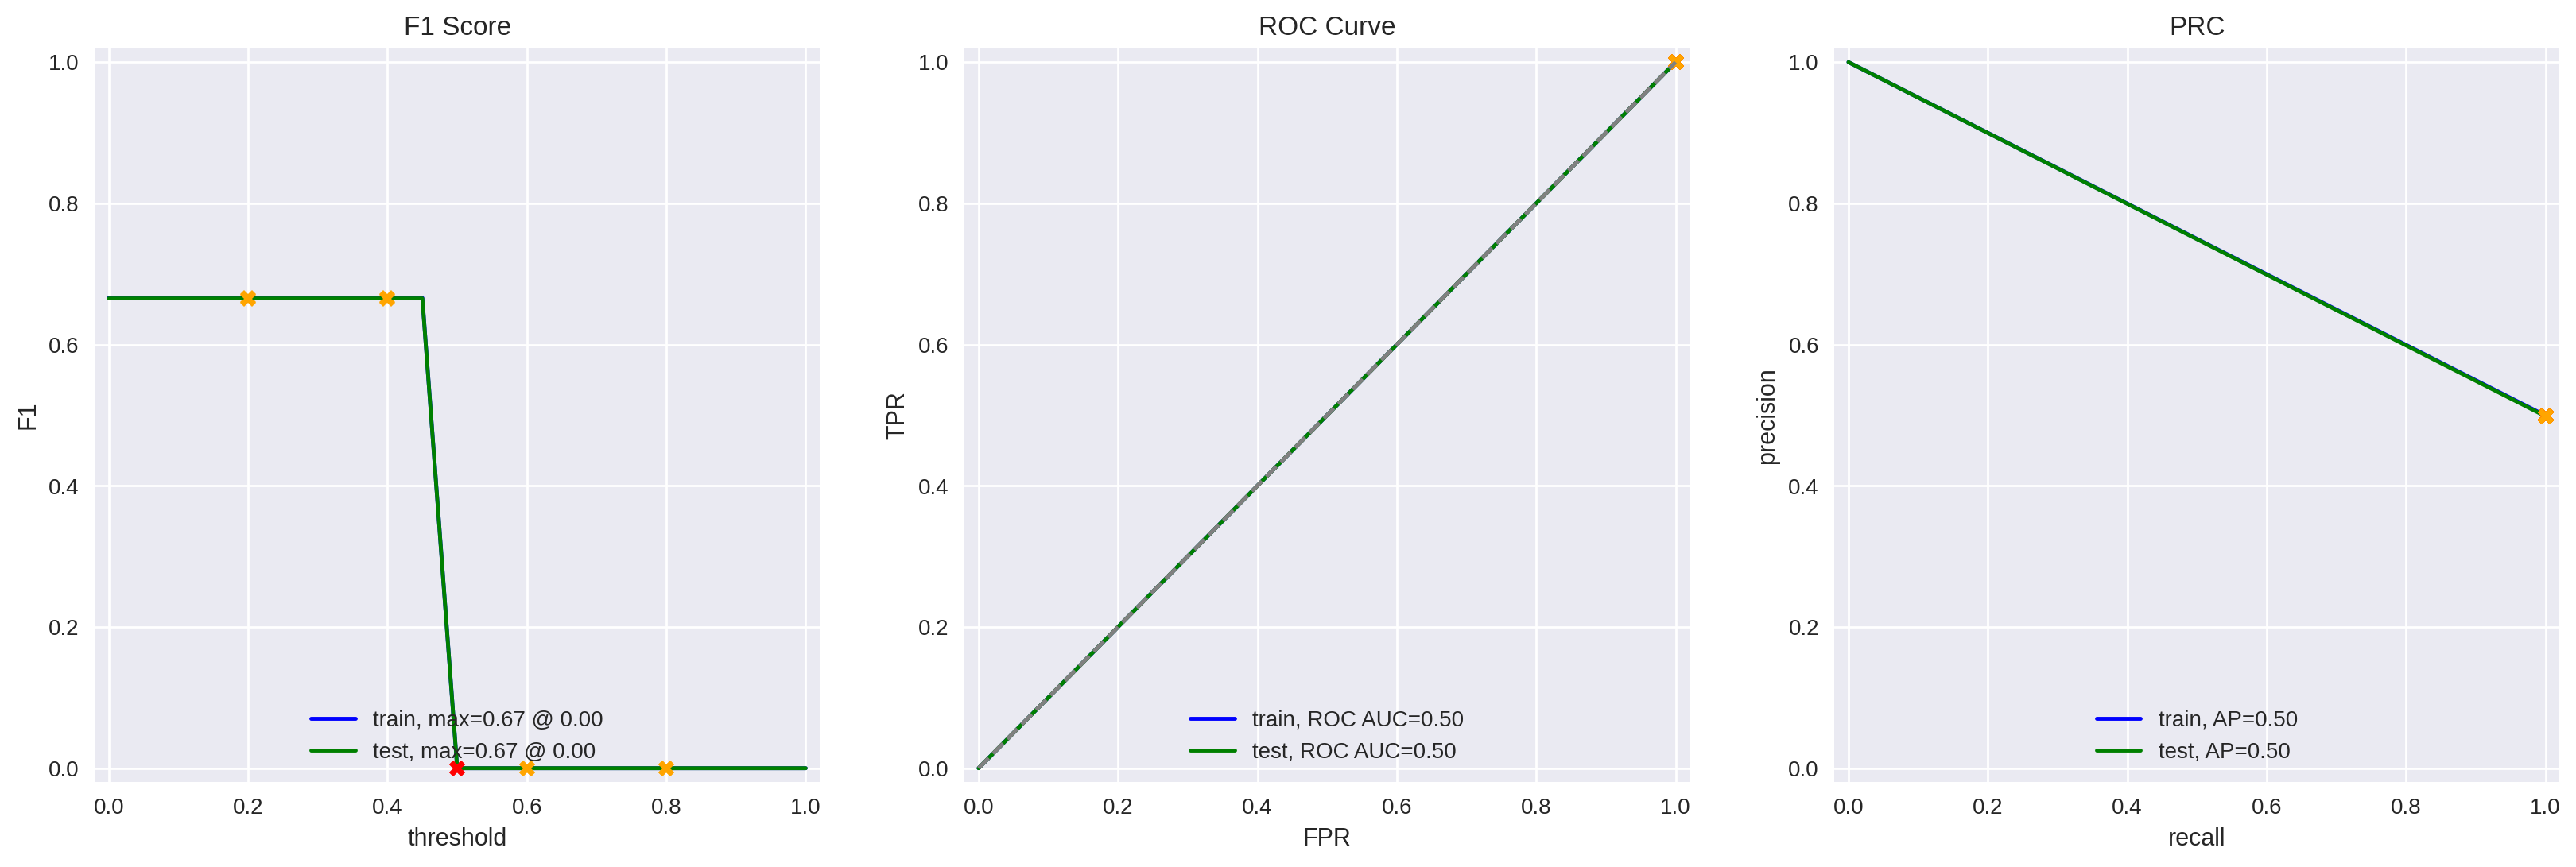

In [18]:
# DummyClassifier
from sklearn.dummy import DummyClassifier

# Instantiate DummyClassifier
model_0 = DummyClassifier()

# Fit model to training data
model_0.fit(features_train, target_train)

# Evaluate model
evaluate_model(model_0, features_train, target_train, features_test, target_test)

### Model 2 - NLTK, TF-IDF and LR

In [19]:
# Natural Language Tool Kit
import nltk

# Convert a collection of raw documents to a matrix of TF-IDF features.
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate LogisticRegression
from sklearn.linear_model import LogisticRegression

# List of stop words to remove
from nltk.corpus import stopwords

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95
CPU times: user 10.7 s, sys: 1.64 s, total: 12.4 s
Wall time: 12.5 s


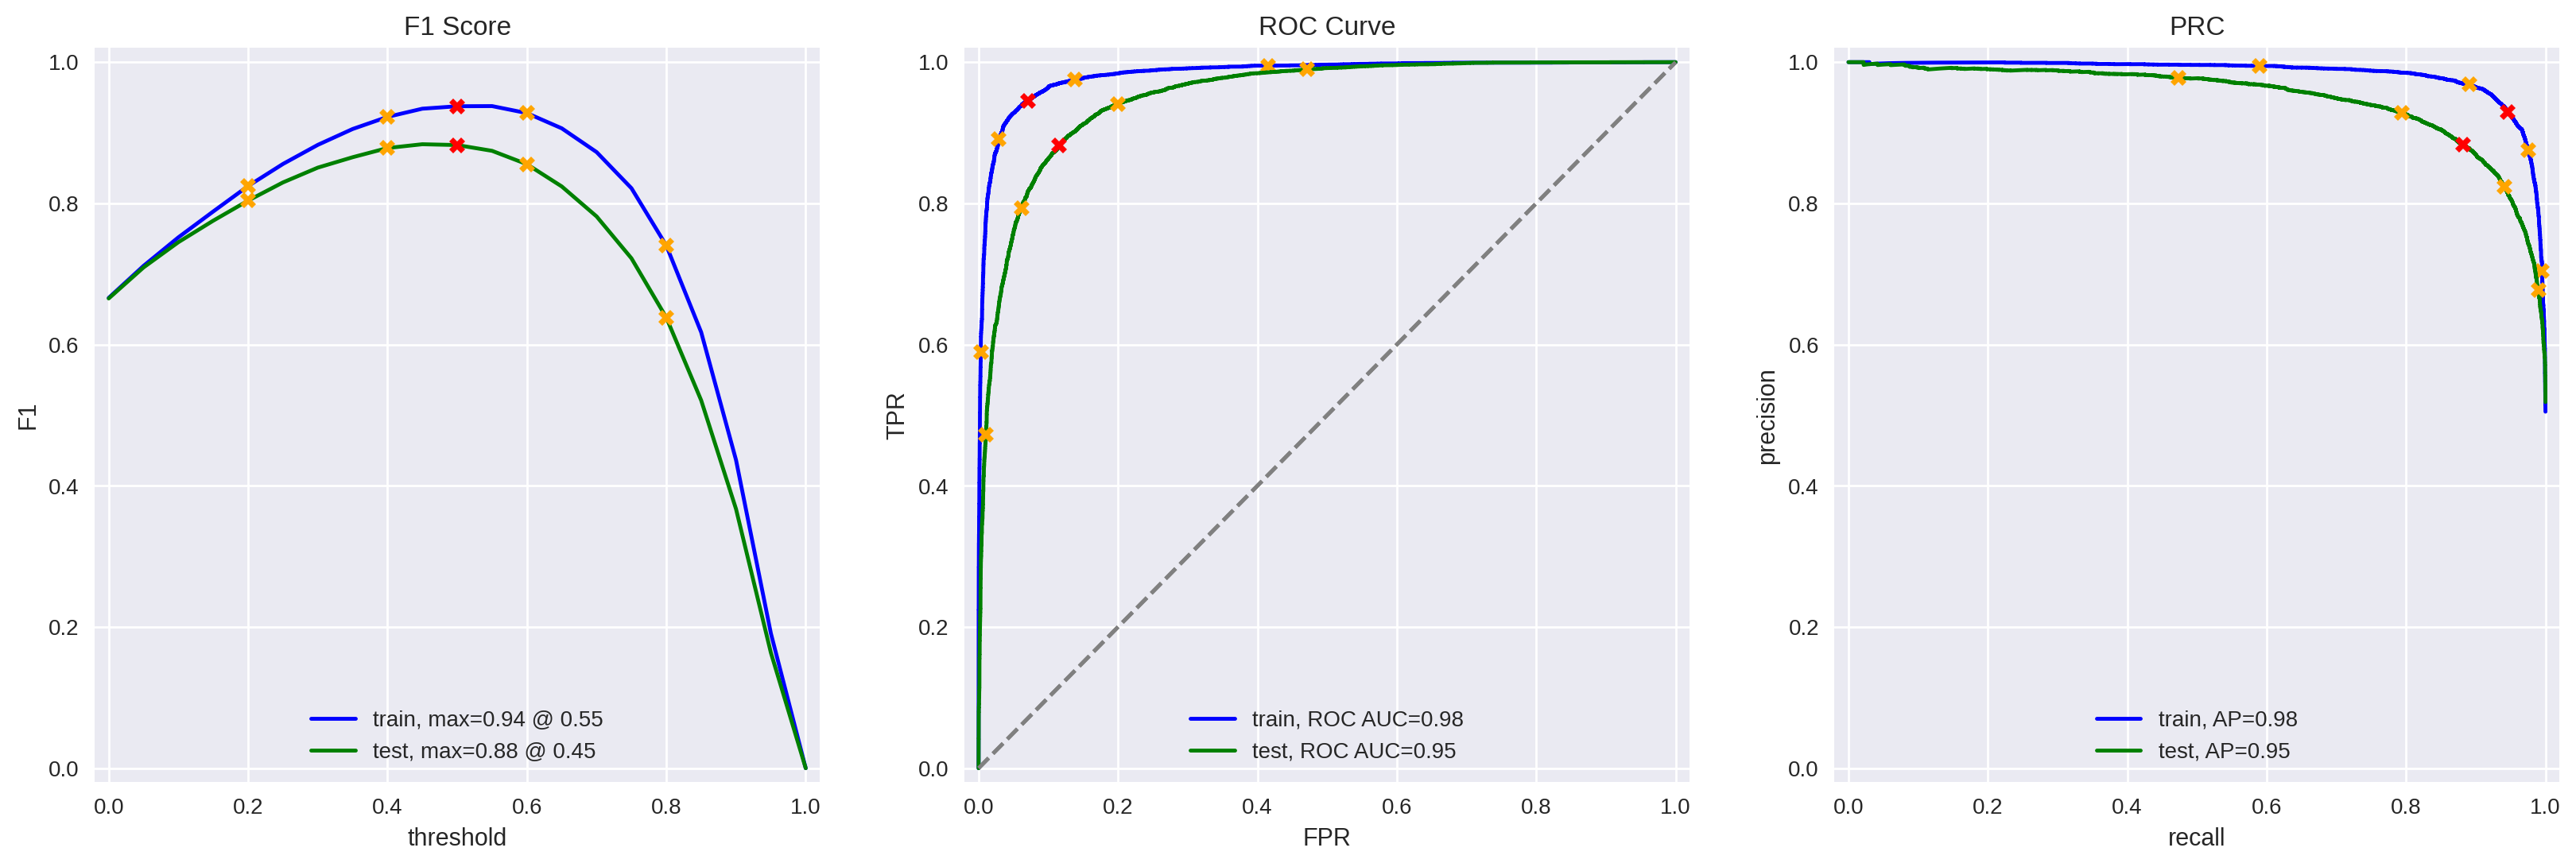

In [20]:
%%time

# Store test and train features to new variable
corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']

# Create list of stopwords which will be removed by TfidfVectorizer
stop_words = stopwords.words('english')

# Convert a collection of raw documents to a matrix of TF-IDF features. Provide stop words
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words)

# Fit tfidf_vectorizer to training corpus and vectorize/transform it 
features_train_2 =  tfidf_vectorizer_2.fit_transform(corpus_train)

# Instantiate LogisticRegression model
model_2 = LogisticRegression(solver= 'liblinear', random_state = 1234)

# Fit LR model to train vectorized features and train target
model_2.fit(features_train_2, target_train)

# Vectorize test corpus 
features_test_2 =  tfidf_vectorizer_2.transform(corpus_test)

# Predcit test targets using transformed test corpus
predictions = model_2.predict(features_test_2)

# Evaluate model using evaluation procedure
evaluate_model(model_2, features_train_2, target_train, features_test_2, target_test)

### Model 3 - spaCy, TF-IDF and LR
**_!!! Note that lemmatizing the text takes upwards of ~16 mins to run !!!_**

In [21]:
# SpaCy is a library for advanced Natural Language Processing
import spacy

# Load the small-size English-language model and disable some components of the pipeline
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [22]:
# Create fucntion for lemmatization to returns words to their base form
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

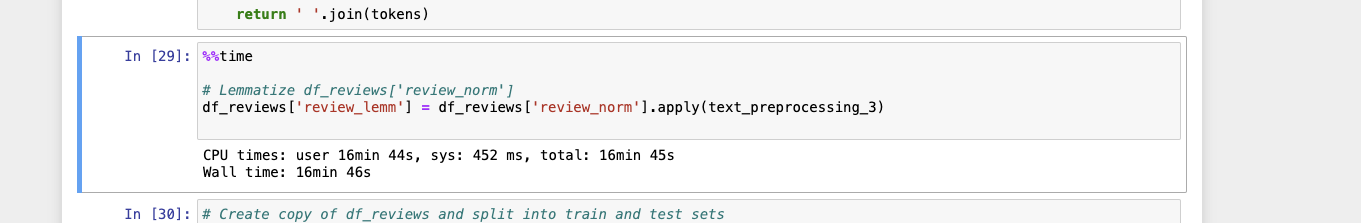

In [23]:
# %%time

# # Lemmatize df_reviews['review_norm']
# df_reviews['review_lemm'] = df_reviews['review_norm'].apply(text_preprocessing_3) 

In [24]:
# Create copy of df_reviews and split into train and test sets
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Store test and train features to new variable
corpus_train = df_reviews_train['review_lemm']
corpus_test = df_reviews_test['review_lemm']

# Create list of stopwords which will be removed by TfidfVectorizer
stop_words = stopwords.words('english')

# Convert a collection of raw documents to a matrix of TF-IDF features. Provide stop words
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)

# Fit tfidf_vectorizer to training corpus and vectorize/transform it 
# Convert the datatype object to unicode string - otherwise I get an error
features_train_3 =  tfidf_vectorizer_3.fit_transform(corpus_train.astype('U'))

# Instantiate LogisticRegression model
model_3 = LogisticRegression(solver= 'liblinear', random_state = 1234)

# Fit LR model to train vectorized features and train target
model_3.fit(features_train_3, target_train)

# Vectorize test corpus 
# Convert the datatype object to unicode string - otherwise I get an error
features_test_3 =  tfidf_vectorizer_3.transform(corpus_test.astype('U'))

# Predcit test targets using transformed test corpus
predictions = model_3.predict(features_test_3)

# Evaluate model using evaluation procedure
evaluate_model(model_3, features_train_3, target_train, features_test_3, target_test)

KeyError: 'review_lemm'

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [ ]:
# Light Gradient Boosting Machine Classifier
from lightgbm import LGBMClassifier

In [ ]:
%%time

# Store test and train features to new variable
corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']

# Create list of stopwords which will be removed by TfidfVectorizer
stop_words = stopwords.words('english')

# Convert a collection of raw documents to a matrix of TF-IDF features. Provide stop words
tfidf_vectorizer_4 = TfidfVectorizer(stop_words=stop_words)

# Fit tfidf_vectorizer to training corpus and vectorize/transform it 
# Convert the datatype object to unicode string - otherwise I get an error
features_train_4 =  tfidf_vectorizer_4.fit_transform(corpus_train)

# Instantiate LGBMClassifier model
model_4 = LGBMClassifier(random_state = 1234)

# Fit LR model to train vectorized features and train target
model_4.fit(features_train_4, target_train)

# Vectorize test corpus 
features_test_4 =  tfidf_vectorizer_4.transform(corpus_test)

# Predcit test targets using transformed test corpus
predictions = model_4.predict(features_test_4)

# Evaluate model using evaluation procedure
evaluate_model(model_4, features_train_4, target_train, features_test_4, target_test)

###  Model 9 - BERT
I will not be using BERT for this project because it is very demanding for computational power and will be very slow on the CPU for the complete dataset. I've removed all cells in this notebook related to BERT

## My Reviews & Model Evaluation
In this section, I composed a few of my own reviews (note I am using the default reviews provided) and classify them with all the models we used in the previous section. Again, I will not be using BERT so I've removed the BERT-related pre-filled cells.

### The Reviews
We will use the models models in the previous section to classify the reviews below

In [ ]:
# Review 
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# Put here the same normalization logic as for the main dataset
my_reviews['review_norm'] = df_reviews['review'].apply(lambda x: " ".join(re.sub(r'[^A-Za-z]', ' ', x.lower()).split()))

# Print reviews
my_reviews

### Model 2
Testing with **NLTK, TF-IDF and LR**

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 3
Testing with **spaCy, TF-IDF and LR**

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 4
Testing with **spaCy, TF-IDF and LGBMClassifier**

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. **The goal is to train a model to automatically detect negative reviews with an F1 score of at least 0.85.** We see that when using different models and methdologies, Models 1,2, and 3 all produce F1 scores higher than 0.85; however, **models using LinearRegression produce the best F1 score.** I would avoid using spaCy going forward because text preprocessing took 16 mins and produced the same results as using NLTK which took significantly less time to run (11 seconds).

| Model/Methodology                          | Test Accuracy | Test F1 | Test APS | Test ROC AUC |
|--------------------------------------------|---------------|---------|----------|--------------|
| Model 0 - DummyClassifier                  | 0.50          | 0.50    | 0.50     | 0.50         |
| Model 1 - NLTK, TF-IDF and LR              | 0.88          | 0.88    | 0.95     | 0.95         |
| Model 2 - spaCy, TF-IDF and LR             | 0.88          | 0.88    | 0.95     | 0.95         |
| Model 3 - spaCy, TF-IDF and LGBMClassifier | 0.86          | 0.86    | 0.93     | 0.94         |